In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
from collections import defaultdict
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

from torchvtk.utils import make_4d, make_5d, tex_from_pts
from torchvtk.rendering import plot_tf

from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D
from torchviz import make_dot

from sklearn.cluster import KMeans

from rle_shit import decode_from_annotation
from moco import MoCo

import wandb

pltkwargs = {
    'dpi':  200,
    'tight_layout': True
}

In [2]:
data = torch.load('/run/media/dome/Data/data/Volumes/CT-ORG/torch/volume_010.pt')
vol = data['vol'].float()
mask = data['mask']

In [3]:
vol.shape, vol.dtype, vol.min(), vol.max()

(torch.Size([512, 512, 501]), torch.float32, tensor(-1024.), tensor(1602.))

Text(0.5, 1.0, 'Sliced along Z')

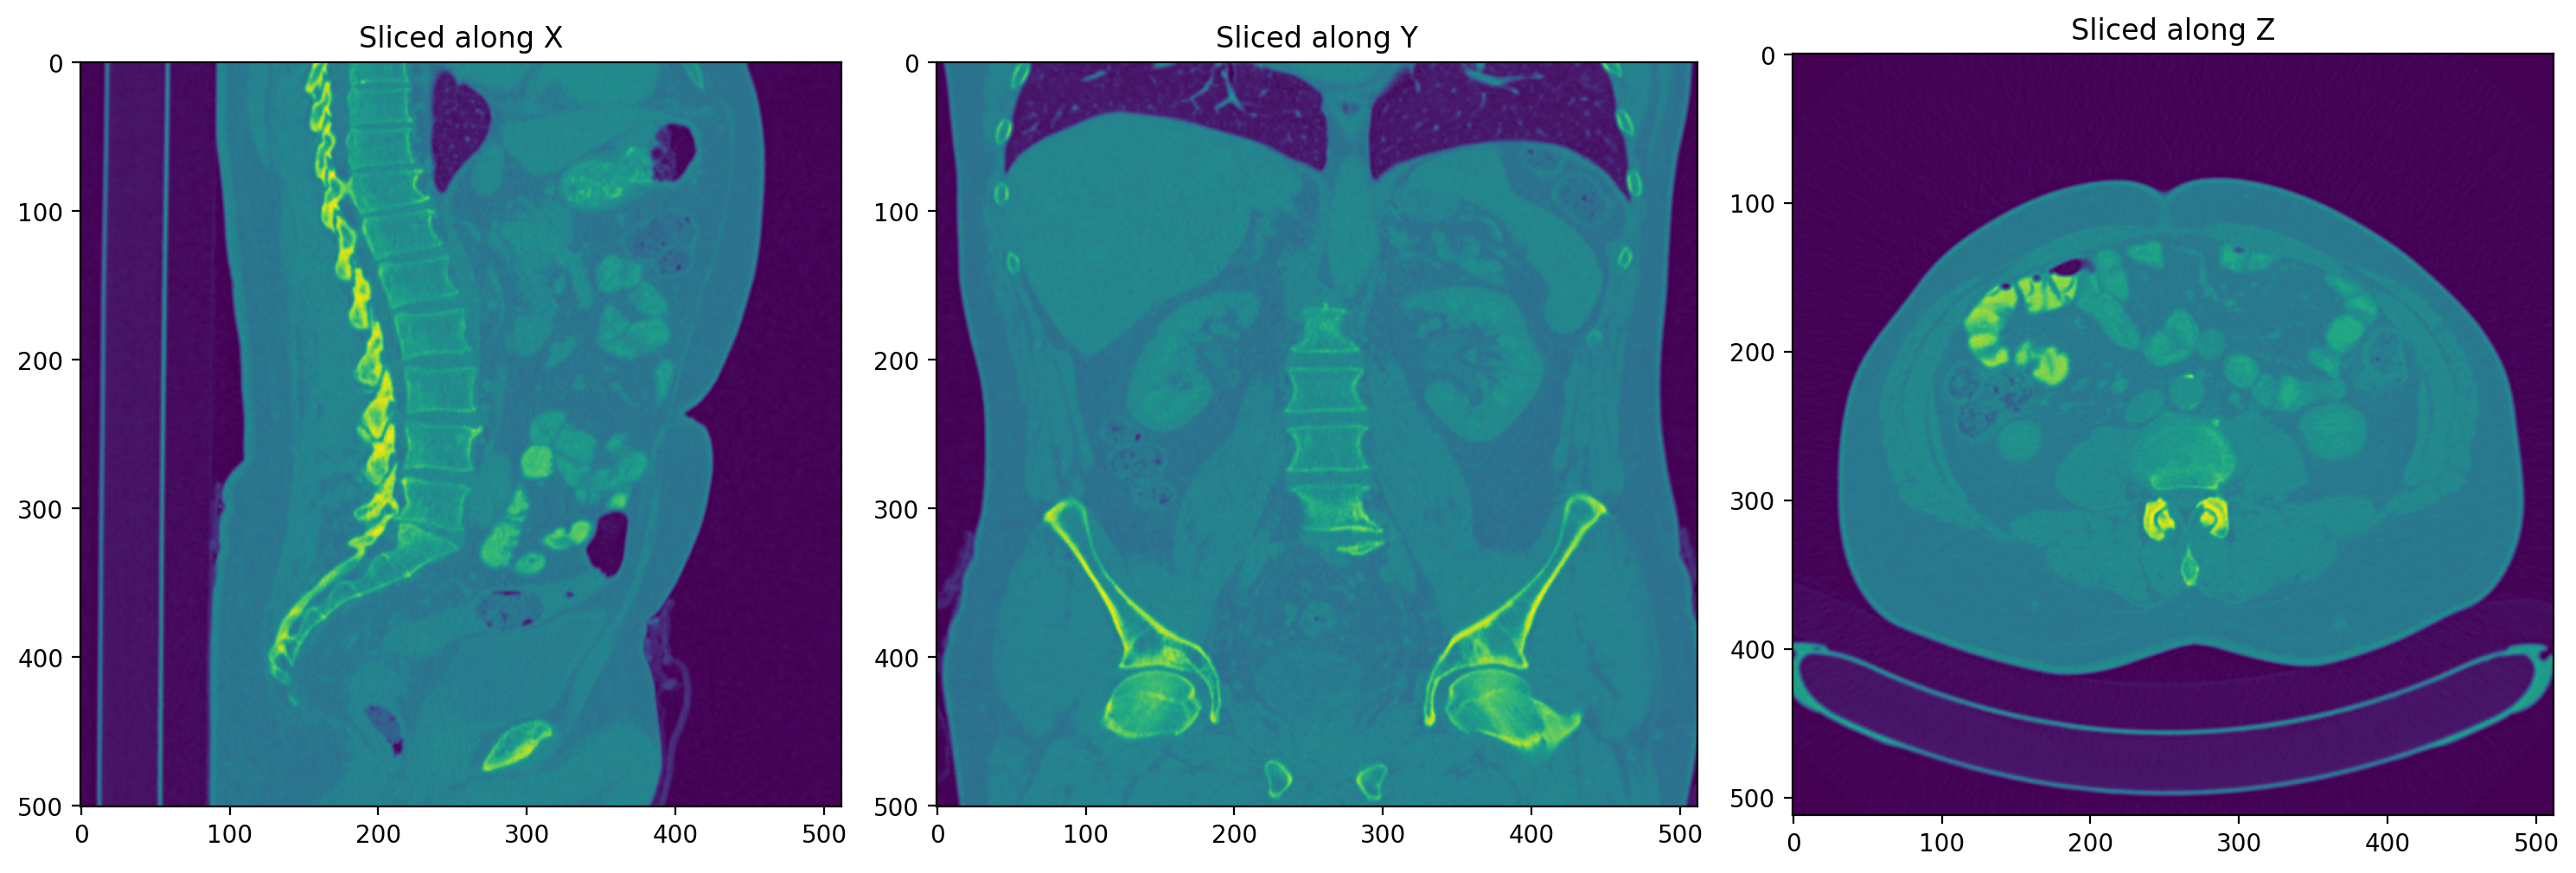

In [4]:
fig, ax = plt.subplots(1,3, figsize=(15,5), **pltkwargs)
ax[0].imshow(vol[250, :, :].rot90())
ax[0].set_title('Sliced along X')
ax[1].imshow(vol[:, 256, :].rot90())
ax[1].set_title('Sliced along Y')
ax[2].imshow(vol[:, :, 256].rot90())
ax[2].set_title('Sliced along Z')


In [5]:
def create_cnn():
    return nn.Sequential(
        nn.GroupNorm(1, 1),
        nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.GroupNorm(8, 8),
        nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.GroupNorm(8, 16),
        nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
    )

## Choose samples from within classes

In [6]:
n_samples = 4096
num_classes = len(data['labels'])
samples_per_class = n_samples // (num_classes-1)
BG_CLASS = 'background'
sample_idxs = { # Dict classname: (2, samples_per_class) indices into class_indices
    n: even_len(torch.randperm(l.size(0))[:2*samples_per_class]).reshape(2, -1)
    for n,l in class_indices.items() if n != BG_CLASS
}
assert len(sample_idxs) == num_classes - 1
bg_samples = n_samples - sum(v.size(1) for v in sample_idxs.values())
sample_idxs[BG_CLASS] = torch.randperm(class_indices[BG_CLASS].size(0))[:2*bg_samples].reshape(2, -1)
# Actually grab the voxel locations, both being dict classname: (samples_per_class, 3)
samples_a = { n: class_indices[n][idx[0]] for n, idx in sample_idxs.items() }
samples_b = { n: class_indices[n][idx[1]] for n, idx in sample_idxs.items() }
# (N, 3)
idxs_a, idxs_b = torch.cat(list(samples_a.values()), dim=0), torch.cat(list(samples_b.values()), dim=0)

NameError: name 'class_indices' is not defined

In [7]:
def make_even(n):
    if n % 2 == 0: return n
    else:          return n-1

def split_squeeze(t, bs, f):
    n = t.size(0)
    X, Y, Z = t[None, None].expand(bs, f, n, 3).split(1, dim=-1)
    BS = torch.arange(bs)[:, None, None].expand(bs, f, n)
    F =  torch.arange(f)[None, :, None].expand(bs, f, n)
    return (BS, F, X.squeeze(-1), Y.squeeze(-1), Z.squeeze(-1))

def similarity_matrix(vectors, mode):
    ''' Computes similarity matrix between F-vectors

    Args:
        vectors (torch.Tensor): vectors of shape (N, F)
    '''
    if mode == 'cosine':
        sim = torch.einsum('nf,mf->nm', [vectors, vectors])
    elif mode == 'l2':
        sim = torch.cdist(vectors.unsqueeze(0), vectors.unsqueeze(0)).squeeze(0)
        sim /= torch.nan_to_num(sim).max()
    else: 
        raise Exception(f'nope for the mode: {mode}')
    return sim

def plot_similarity_matrix(sim, labels, mode):
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    cax = ax.matshow(sim, interpolation='nearest')
    ax.grid(True)
    ax.set_title(f'Similarity ({mode})')
    ax.set_xticks(range(len(labels)), labels, rotation=90)
    ax.set_yticks(range(len(labels)), labels)
    fig.colorbar(cax, ticks=[-1.0, -.8, -.6, -.4, -.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    return fig


## SimCLR train loop

In [8]:
# Setup
BG_CLASS = 'background'
N_SAMPLES = 4096
FP16 = True
HALF_RES = True

# Model
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
typ = torch.float16 if FP16 else torch.float32
model = create_cnn().to(dev)
ONE = torch.ones(1, device=dev)

# Data
data = torch.load(
    '/run/media/dome/Data/data/Volumes/CT-ORG/torch/volume_010.pt')
if HALF_RES:
    vol  = F.interpolate(make_5d(data['vol']).float(), scale_factor=0.25, mode='nearest').squeeze().to(typ).to(dev)
    mask = F.interpolate(make_5d(data['mask']),        scale_factor=0.25, mode='nearest').squeeze()
else:
    vol  = data['vol'].to(typ).to(dev)
    mask = data['mask']

num_classes = len(data['labels'])
class_indices = {
    n: (mask == i).nonzero().to(dev)
    for i, n in enumerate(data['labels'])
}
sample_idxs = { n: l.size(0) for n, l in class_indices.items() }

{n: v.shape for n, v in class_indices.items()}, sample_idxs


({'background': torch.Size([1859446, 3]),
  'liver': torch.Size([45050, 3]),
  'bladder': torch.Size([5020, 3]),
  'lung': torch.Size([60848, 3]),
  'kidney': torch.Size([9855, 3]),
  'bone': torch.Size([67781, 3]),
  'brain': torch.Size([0, 3])},
 {'background': 1859446,
  'liver': 45050,
  'bladder': 5020,
  'lung': 60848,
  'kidney': 9855,
  'bone': 67781,
  'brain': 0})

In [9]:
# Dictionary that maps class to indices that are of a DIFFERENT class, for picking negatives
different_class_indices = { n: torch.cat([v for m,v in class_indices.items() if m != n], dim=0) for n in class_indices.keys() }
different_sample_idxs = { n: v.size(0) for n,v in different_class_indices.items() }
{n: v.shape for n, v in different_class_indices.items()}, different_sample_idxs


({'background': torch.Size([188554, 3]),
  'liver': torch.Size([2002950, 3]),
  'bladder': torch.Size([2042980, 3]),
  'lung': torch.Size([1987152, 3]),
  'kidney': torch.Size([2038145, 3]),
  'bone': torch.Size([1980219, 3]),
  'brain': torch.Size([2048000, 3])},
 {'background': 188554,
  'liver': 2002950,
  'bladder': 2042980,
  'lung': 1987152,
  'kidney': 2038145,
  'bone': 1980219,
  'brain': 2048000})

In [10]:
hparams = {
    'learning_rate': 1e-3,
    'iterations': 10001,
    'samples_per_opt': 16
}
wandb.init(project='ntf', entity='viscom-ulm')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xetaiz (viscom-ulm). Use `wandb login --relogin` to force relogin


In [11]:
# Optimize
scaler = torch.cuda.amp.GradScaler()
opt = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])
wandb.watch(model)
for i in range(10001):
    opt.zero_grad()
    # 1 Feed volume thru networks
    with torch.autocast('cuda', enabled=True, dtype=typ):
        features = model(make_5d(vol))
        q = F.normalize(features, dim=1)
    # 2 Choose samples from classes
    BS, FS = q.size(0), q.size(1)
    loss = 0.0
    for _ in range(hparams['samples_per_opt']):
        pos_samples = { # Pick samples_per_class indices to `class_indices`
            n: torch.multinomial(ONE.expand(v), 2)
            for n,v in sample_idxs.items() if v >= 2 and n != BG_CLASS
        }
        neg_samples = { # Pick samples_per_class indices to `class_indices`
            n: torch.multinomial(ONE.expand(v), int(2**16))
            for n,v in different_sample_idxs.items() if n != BG_CLASS
        }
        # 3 Sample samples
        for n, pos_idx in pos_samples.items():
            neg_idx = neg_samples[n]
            pos = q[split_squeeze(          class_indices[n][pos_idx], bs=BS, f=FS)]
            neg = q[split_squeeze(different_class_indices[n][neg_idx], bs=BS, f=FS)]
            sim = torch.einsum('bfp,bfn->bpn', [pos[..., [0]], torch.cat([pos[..., [1]], neg], dim=-1)]).squeeze(1)
            labels = torch.zeros(sim.size(0), dtype=torch.long, device=dev)
            loss += F.cross_entropy(sim, labels)

    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()

    with torch.no_grad():
        temp_cluster_center_cos = torch.stack([        q[split_squeeze(v, bs=BS, f=FS)].mean(dim=(0,2)) for n,v in class_indices.items() ])
        temp_cluster_center_l2  = torch.stack([ features[split_squeeze(v, bs=BS, f=FS)].mean(dim=(0,2)) for n,v in class_indices.items() ])
        if i > 0:
            cos_dist_traveled = 1.0 - torch.einsum('nf,mf->nm', [cluster_center_cos, temp_cluster_center_cos]).diagonal()
            l2_dist_traveled = F.pairwise_distance(temp_cluster_center_l2, cluster_center_l2)
        else: 
            cos_dist_traveled, l2_dist_traveled = torch.zeros(temp_cluster_center_cos.size(0)), torch.zeros(temp_cluster_center_cos.size(0))
        # Update "old" cluster centers with current "temp" ones
        cluster_center_l2 = temp_cluster_center_l2
        cluster_center_cos = temp_cluster_center_cos

        cos_sim = similarity_matrix(cluster_center_cos.float(), 'cosine')
        l2_sim  = similarity_matrix(cluster_center_l2.float(),   'l2')
        cos_sim_fig = plot_similarity_matrix(cos_sim.cpu(), data['labels'], 'cosine')
        l2_sim_fig  = plot_similarity_matrix(l2_sim.cpu(),  data['labels'], 'l2')

        log_dict = {
            'loss': loss,
            'plots/cosine_similarity': cos_sim_fig,
            'plots/l2_similarity': l2_sim_fig
        }
        log_dict.update({
                f'std_norm/{n}':         q[split_squeeze(v, bs=BS, f=FS)].std().cpu()
                for n,v in class_indices.items() }
            )
        log_dict.update({
                f'std_logit/{n}': features[split_squeeze(v, bs=BS, f=FS)].std().cpu()
                for n,v in class_indices.items() }
            )
        log_dict.update({
                f'l2_dist_traveled/{n}': l2_dist_traveled[i].cpu()
                for i, n in enumerate(class_indices.keys()) }
            )
        log_dict.update({
                f'cos_dist_traveled/{n}': cos_dist_traveled[i].cpu()
                for i, n in enumerate(class_indices.keys()) }
            )
        wandb.log(log_dict)
    # # Valid
    # if i % 1000 == 0:
    #     with torch.no_grad():
    #         losses.append(loss.detach().cpu().item())
    #         km = KMeans(n_clusters=num_classes)
    #         km.fit(features.permute(0, 2, 3, 4, 1).reshape(-1, features.size(1)).cpu())
    #         pred = km.labels_.reshape(*features.shape[-3:])
    #         preds.append(pred)

/tmp/ipykernel_704900/772863626.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1,figsize=(5,5))


In [127]:
l2_dist_traveled, cos_dist_traveled, cluster_center_l2.shape, temp_cluster_center_l2.shape

(0, 0, torch.Size([7, 16]), torch.Size([7, 16]))

In [66]:
cc = torch.stack(list(cluster_centers.values()))
cc.shape

torch.Size([7, 16])

In [61]:
cluster_centers = {}
for n, idx in class_indices.items():
    cluster_centers[n] = features.detach()[split_squeeze(idx, bs=features.size(0), f=features.size(1))].mean(dim=(0,2))

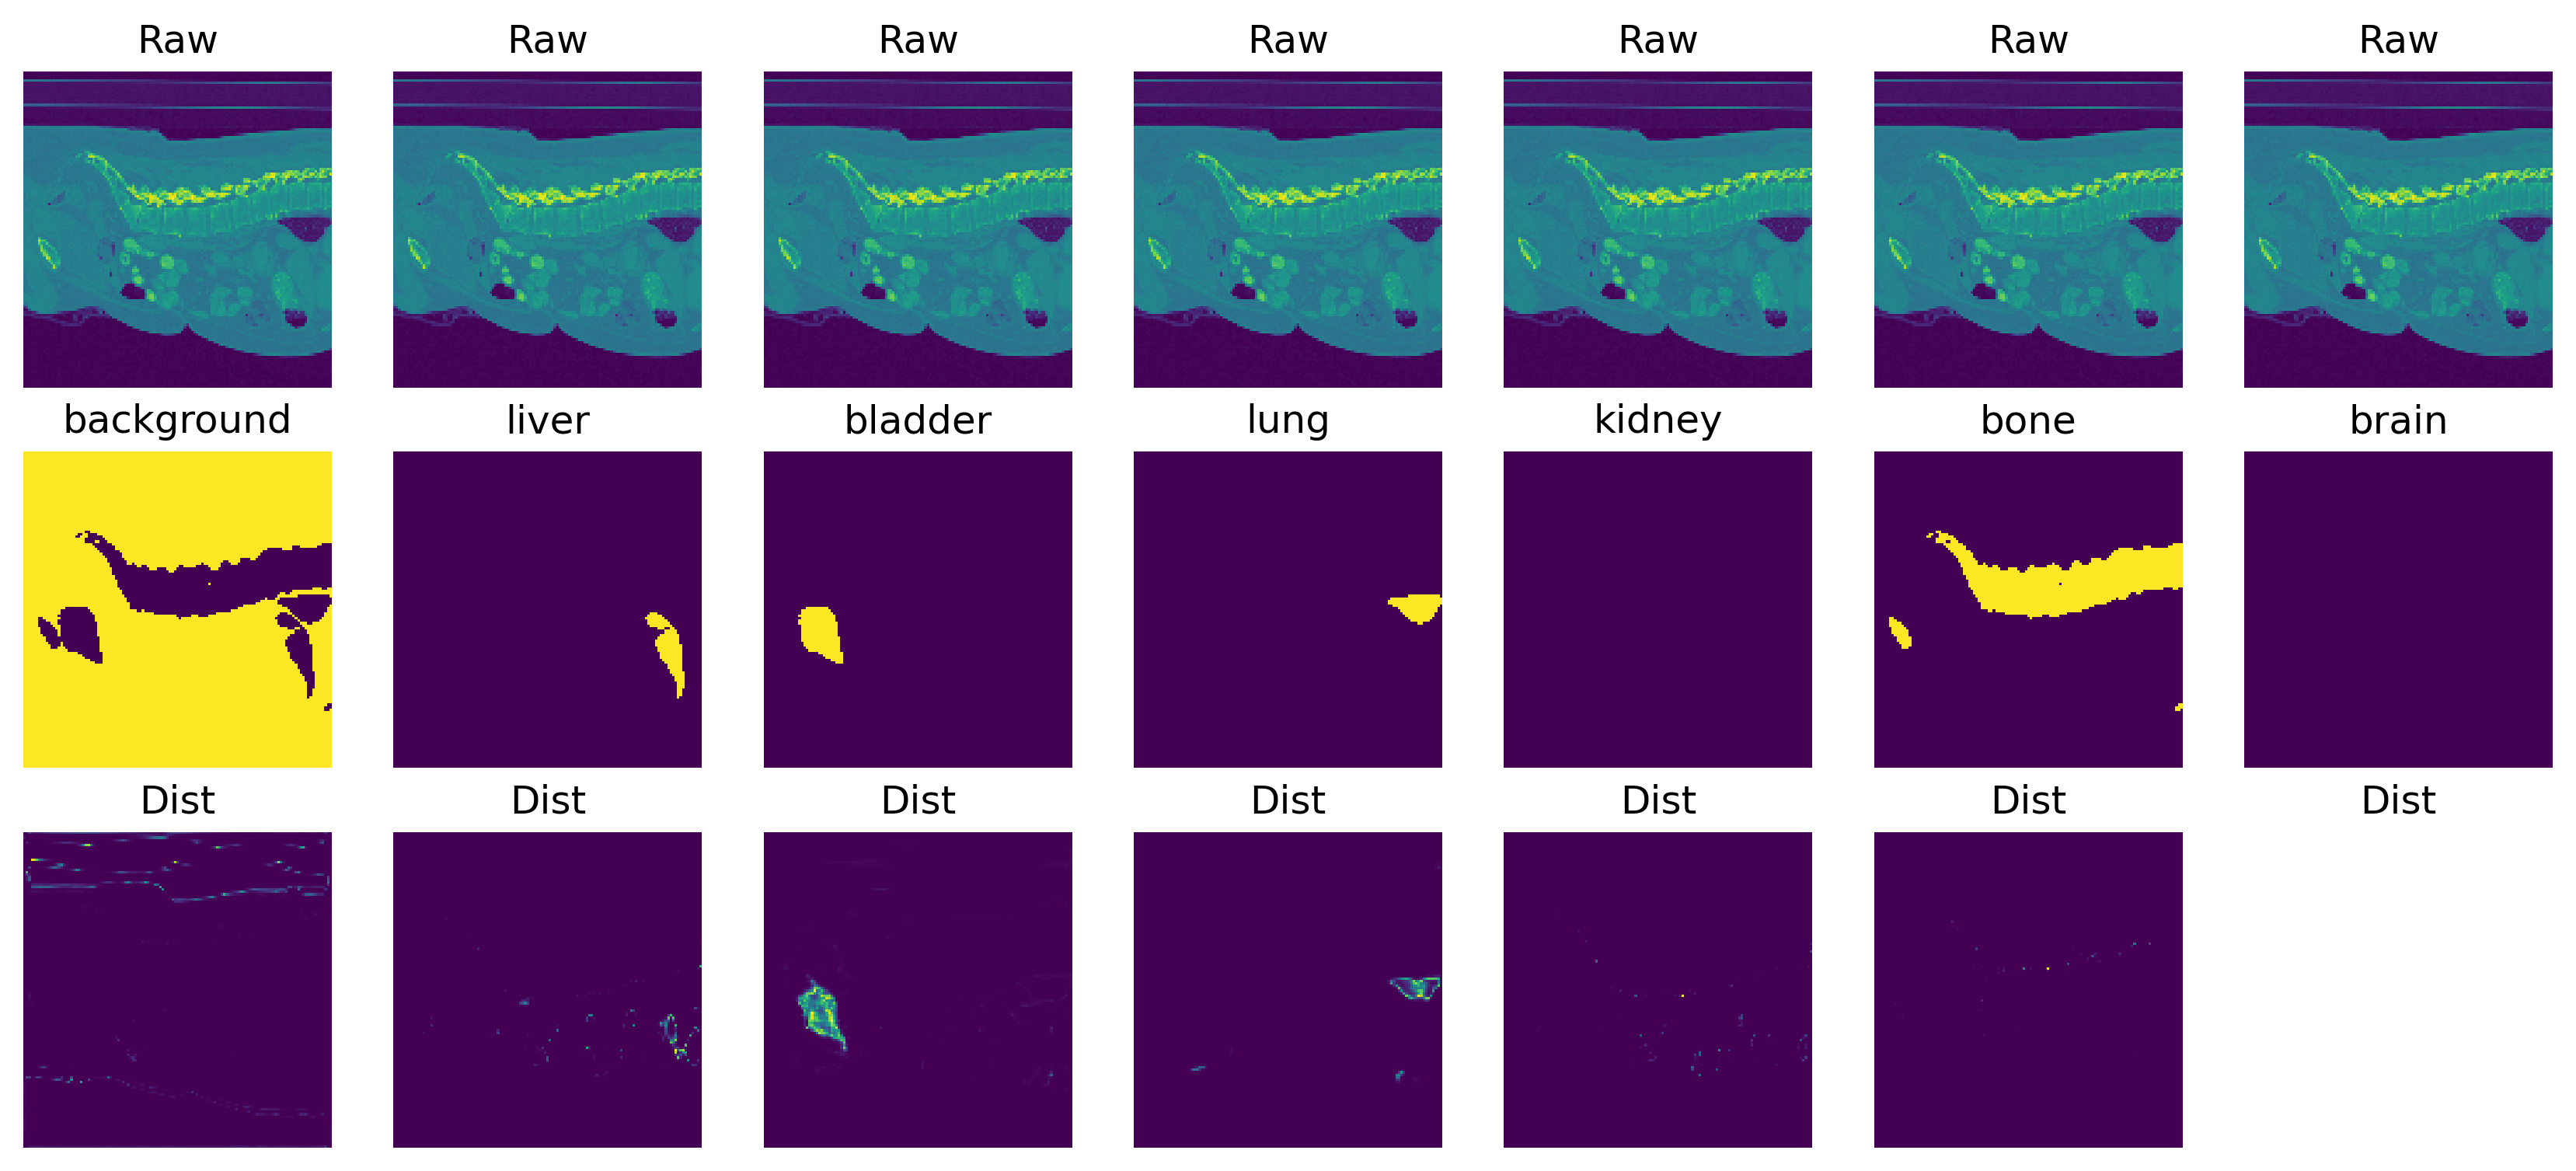

In [62]:
fig, ax = plt.subplots(3,num_classes, dpi=300, figsize=(num_classes*2,6))
vol_slice = vol.detach().squeeze()[62,:,:]
mask_slice = mask.detach().squeeze()[62, :, :]
feat_slice = features.detach().squeeze()[:, 62, :, :]
for i, cc in enumerate(cluster_centers.items()):
    n, center = cc
    ax[0,i].imshow(vol_slice.cpu())
    ax[0,i].set_title(f'Raw')
    ax[1,i].imshow(mask_slice.cpu() == i)
    ax[1,i].set_title(n)
    ax[2,i].imshow(torch.exp(-(feat_slice - center[:,None,None]).norm(dim=0)).cpu())
    ax[2,i].set_title(f'Dist')
for x in ax.reshape(-1): x.set_axis_off()

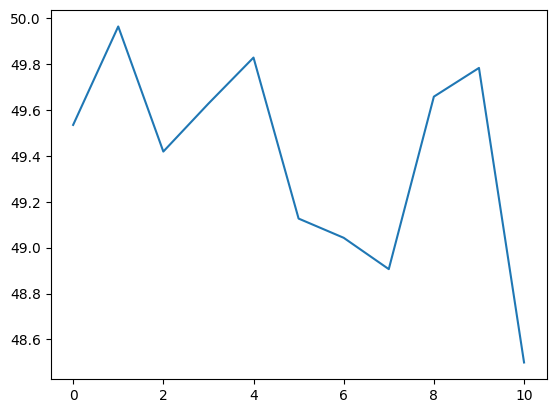

In [63]:
plt.plot(losses)

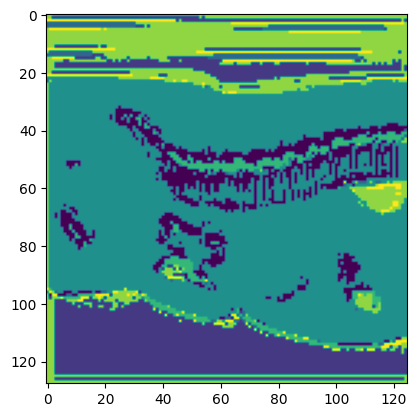

In [56]:
plt.imshow(preds[0][62,:,:])

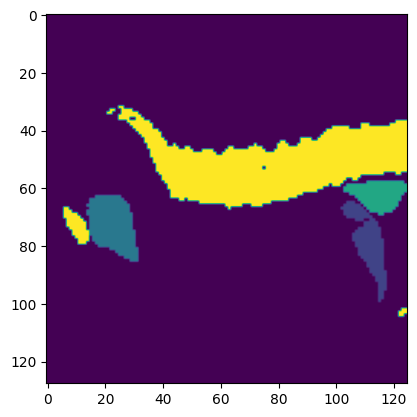

In [55]:
plt.imshow(mask.detach().squeeze().cpu()[62,:,:])